In [ ]:
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

# PyTorch and dependencies

In [ ]:
SEED = 36

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

Mount the drive and import the dataset into the colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/dataset/'
os.listdir(DATA_PATH)

['nightTrain',
 'sample-dayClip6',
 'sample-nightClip1',
 'daySequence2',
 'Annotations',
 'dayTrain',
 'daySequence1',
 'nightSequence1',
 'nightSequence2',
 'train',
 'val',
 'test']

In [ ]:
DAY_TRAIN_PATH = '/content/drive/MyDrive/dataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '/content/drive/MyDrive/dataset/Annotations/Annotations/nightTrain/'

# Data Processing
Now, we should see the data being processed in following code:

In [ ]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)

train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0

train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


In [ ]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


Removing the duplicate columns and dropping unnecessary ones as well.

In [ ]:
# Duplicate Columns
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [ ]:
# Droppin duplicate columns & "Origin file" as we don't need it
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [ ]:
# Here Filename (Location of Image) is different -> Change it to appropriate name

def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight

    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename, axis=1)

In [ ]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [ ]:
#Change annotations to only -> stop (RED), go (GREEN) & warning (YELLOW)
label_to_idx = {'go':0, 'warning':1, 'stop': 2}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']

df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([0, 2, 1])

In [ ]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0


In [ ]:
# Changing Column Names
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [ ]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0


In [ ]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


We then plot and visualize the three examples in random images:

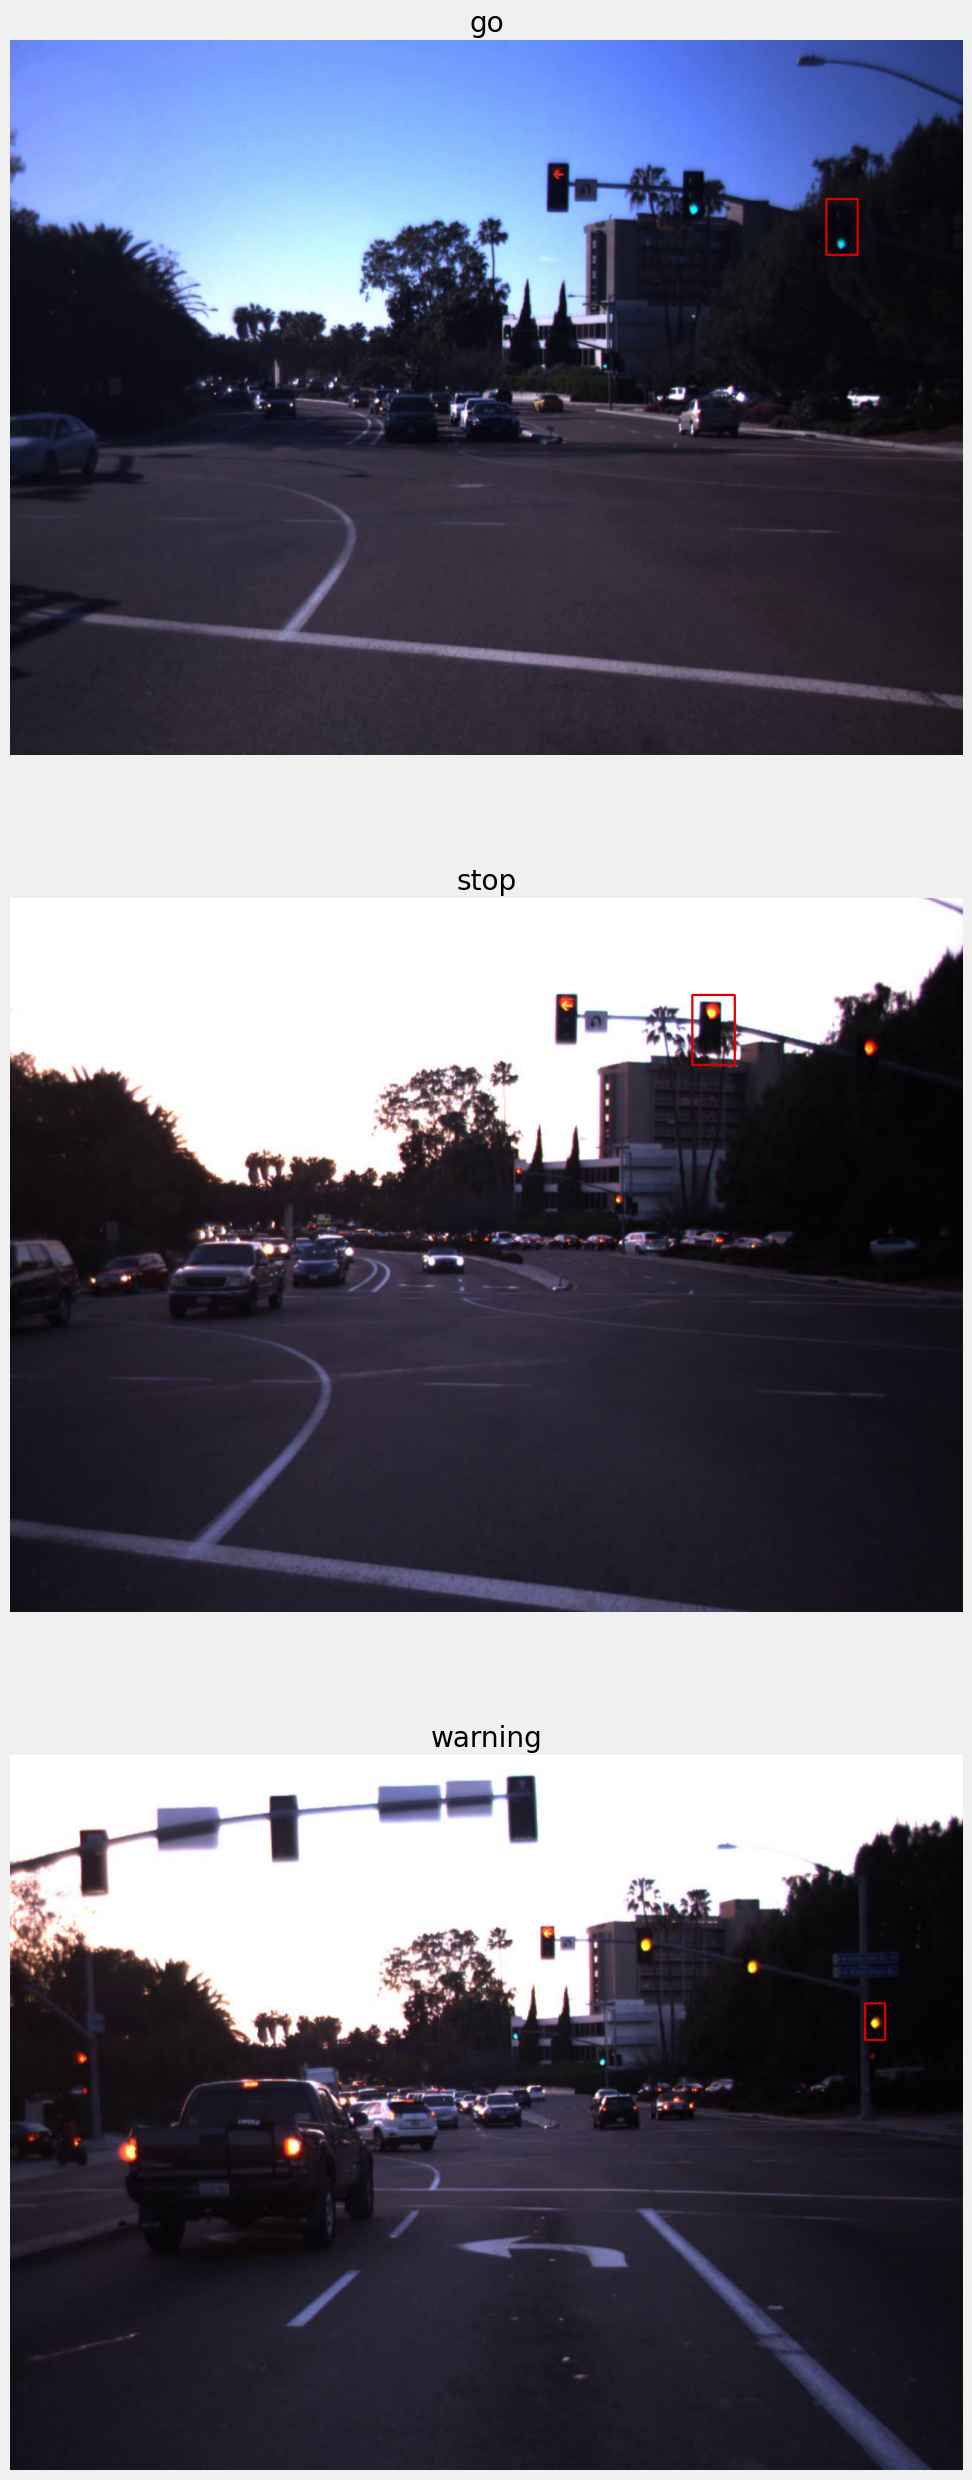

In [ ]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]

    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)

    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

Getting the total number of folders

In [ ]:
def extract_clip_name(image_path):
    parts = image_path.split('/')
    for part in parts:
        if 'Clip' in part:
            return part.split('--')[0]

df['clipNames'] = df['image_id'].apply(extract_clip_name)
print(df['clipNames'].unique())
#print(df['clipNames'])

['dayClip1' 'dayClip10' 'dayClip11' 'dayClip12' 'dayClip13' 'dayClip2'
 'dayClip3' 'dayClip4' 'dayClip5' 'dayClip6' 'dayClip7' 'dayClip8'
 'dayClip9' 'nightClip1' 'nightClip2' 'nightClip3' 'nightClip4'
 'nightClip5']


Splitting data frames

In [ ]:
def split(df,p=0.20):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames

    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]

    return train_df, test_df

In [ ]:
train_df, test_df = split(df)

In [ ]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,323,288,335,308,0,0,dayClip10
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,506,376,518,396,0,0,dayClip10
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,587,369,599,389,0,0,dayClip10
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,210,261,222,279,0,0,dayClip10
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,330,286,342,306,1,0,dayClip10


In [ ]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0,dayClip1
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0,dayClip1
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0,dayClip1
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0,dayClip1
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0,dayClip1


In [ ]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (37408, 9)
Test shape:  (14418, 9)


In [ ]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,323,288,335,308,0,0,dayClip10
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,506,376,518,396,0,0,dayClip10
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,587,369,599,389,0,0,dayClip10
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,210,261,222,279,0,0,dayClip10
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,330,286,342,306,1,0,dayClip10


In [ ]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,412,234,442,270,0,0,dayClip8
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,881,359,896,381,0,0,dayClip8
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,775,354,799,376,0,0,dayClip8
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,410,229,434,269,1,0,dayClip8
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,882,358,894,376,1,0,dayClip8


In [ ]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (35415, 9)
Validation shape:  (1993, 9)


Assigning Hyperparameters

In [ ]:
EPOCHS = 3
BATCH_SIZE = 16

Recommended device for running and testing is GPU.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Creating a class for custom dataset

In [ ]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)

        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)

        iscrowd = torch.zeros_like(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])

        return image, target, image_id

Creating a LossAverager class to periodically check the model performance

In [ ]:
# Average loss -> (Total-Loss / Total-Iterations)
class LossAverager:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

Data Augmentation

In [ ]:
# Albumentations

# For Train Data
def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Validation Data
def getValTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Test Data
def getTestTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

Putting the dataset values in the dataloader for train, val and test corresponding each equally

In [ ]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [ ]:
targets[0]

{'boxes': tensor([[125.2000, 400.0000, 144.4000, 448.0000],
         [ 38.8000, 371.2000,  62.8000, 432.5333],
         [201.2000, 398.9333, 225.2000, 444.2667]]),
 'labels': tensor([0, 0, 2]),
 'image_id': tensor([5073]),
 'area': tensor([4320., 6900., 5100.]),
 'iscrowd': tensor([0, 0, 0])}

In [ ]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()


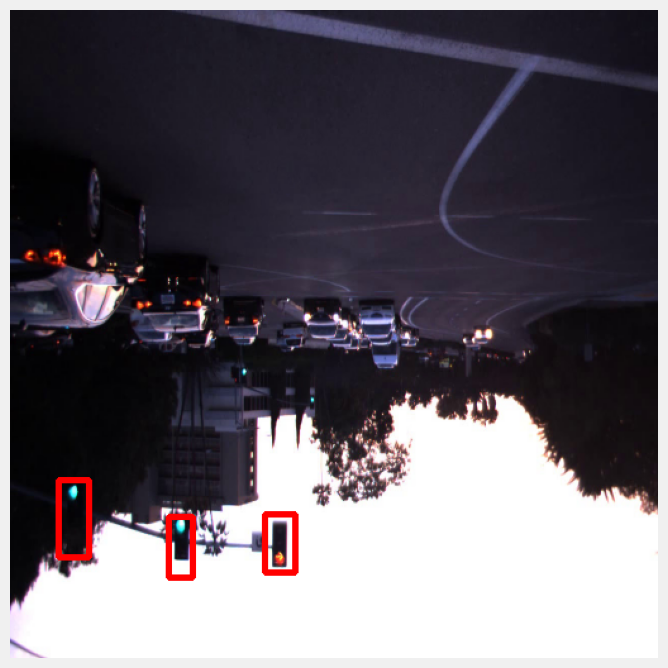

In [ ]:
displayImage(image,boxes)

# Model
We choose the model now

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]


In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Training
We now train our model and observe the average loss go down.

In [ ]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):

    start_time = time()
    model.train()
    lossHist.reset()

    for images, targets, image_ids in tqdm(trainDataLoader):

        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        bs = images.shape[0]

        loss_dict = model(images, targets)

        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()

        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()

    # LR Update
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")

    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

100%|██████████| 758/758 [34:35<00:00,  2.74s/it]


[34:36]
Epoch 0/3
Train loss: 0.2208311975611703


100%|██████████| 758/758 [34:24<00:00,  2.72s/it]


[34:25]
Epoch 1/3
Train loss: 0.0979440429771324


100%|██████████| 758/758 [34:16<00:00,  2.71s/it]


[34:17]
Epoch 2/3
Train loss: 0.08669651469269811


Reloading the previously saved model

In [ ]:
# model.load_state_dict(torch.load('../input/trafficlightdetectionfasterrcnnweights/fasterrcnn_resnet50_fpn.pth'))
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

In [ ]:
# Move the model to CPU
model = model.to('cpu')

# Set the model to evaluation mode
model.eval()

# Load a batch of images
images, targets, image_ids = next(iter(testDataLoader))

# Move the images to CPU
images = torch.stack(images).to('cpu')

# Run inference
outputs = model(images)


Keep the best bounding box and discard the redundant ones.

In [ ]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):

    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']

    mask = nms(boxes,scores,nms_th)

    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()

    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    return boxes, scores, labels

In [ ]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):

    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)

    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}

    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

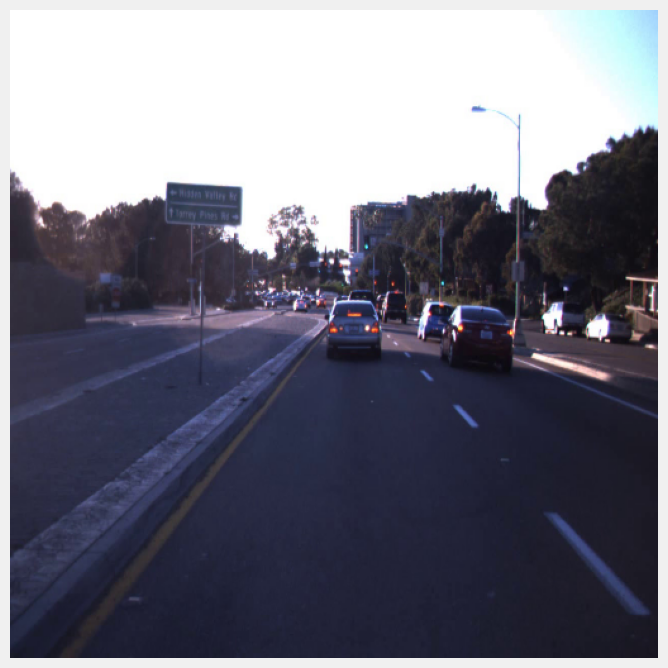

In [ ]:
displayPredictions(image_ids[0],outputs[0],0.2,0.4)